# Implementation of InfoGAN

### Testing Environment
* GPU==RTX3090
* torch==1.9.0+cu111
* scikit-learn==0.24.2
* numpy==1.19.5
* torchvision
* pillow
* urllib3
* scikit-image
* scipy
* numpy
* matplotlib

### Issue on Downloading the MNIST dataset
* Sometimes, there are errors in downloading the MNIST. You may approach the MNIST through the below URL.
https://drive.google.com/drive/folders/1SzwS6lLjeAXYkCjPou8AWFxSLnHW4sMS?usp=sharing


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
import time
import random

import numpy as np
import datetime
import os, sys
import math
import matplotlib.pyplot as plt

os.makedirs("data/mnist", exist_ok=True)  # data/mnist directory 생성
# Setting parameters
device = torch.device('cuda' if torch.cuda.is_available else 'cpu') # gpu 지원 여부에 따라 어떤 device를 사용할 지 결정

# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


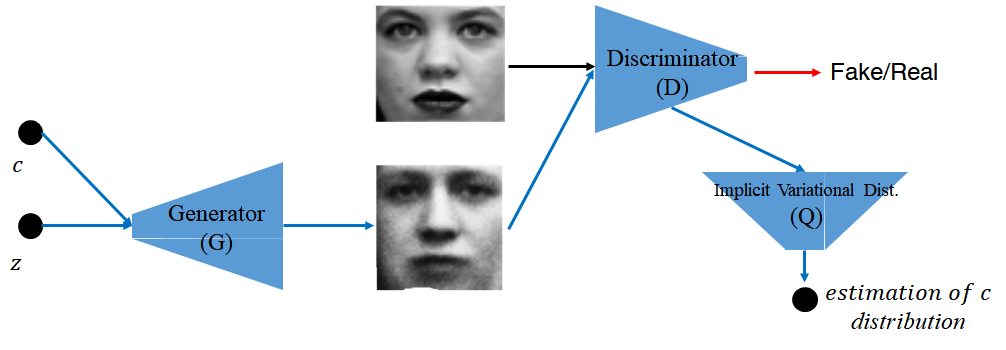


### Task 1. Implement the model structure of InfoGAN 
We provide the basic skeleton code of InfoGAN. The training procedure will be Task 2, so you can only focus on the model structure.
We will define four classes to represent three networks.
* class Generator : the generator network. ***G(z,c)=x***
* class Discriminator : the discriminator structure up to the representation learning part, without the classification.
* class DHead : the final classification layer of the discriminator by taking the forwarded values from the Discriminator instance, ***D(x)=0 or 1***
* class QHead : the final distribution estimation layer of Q network by taking the forwarded values from the Discriminator instance, ***Q(x)=(estimation of the c distribution)***

All four classes will inherit the **nn.Module** of PyTorch. As the inheritance, the codes should override the constructor of **\_\_init__** and the neural network data forward function of **forward**.

* **\_\_init__** : should setup the neural network structure, and its hyperparameters are up to your choice. Only limited scale is the dimension of ***z*** to be 62, and the dimension of ***c*** to be 10-dim discrete multinomial selection variables and 2-dim continuous latent variables following the Normal.
* **forward** : should propagate the appropriate input, either images or neural network hidden values; and should return the expected output of the function.



The below code block can be used for your utility class and function defintions and calls.
It is fine to leave it as a blank if you do not need such codes. 

In [2]:
###############################################
# You can use this code box to declare some global variables to set parameters
# - icmoon


batch_size = 64
num_epochs = 3
learning_rate = 2e-4
beta1 = 0.5
beta2 = 0.999


num_z = 62
num_dis_c = 1
dis_c_dim = 10
num_con_c = 2


real_label = 1
fake_label = 0

Complete the below code to implement **Generator**.
* should inherit **nn.Module**
* ***\_\_init__(self,z_size,code_size)*** : **z_size** is the stochastic input dimension to make the generator to be a probability distribution. **code_size** is the condition input dimension, which is set to be 10 discrete dimensions of 1 or 0 and 2 continuous dimensions from Normal distribution, so the total dimension of **code_size** is 12 in this setting.  You need to setup the neural network structure in this function.
* ***forward(self, z,code)*** : **z** is the sample of the stochastic input, and **code** is the conditional input of the 12 dimensions. 
* ***sample(self, lstDiscreteLatentCondition, lstContinuousLatentCondition)*** : **lstDiscreteLatentCondition** is the condition of 10 discrete dimensions, and **lstContinuousLatentCondition** is the condition of 2 continuous dimensions.

In [3]:
class Generator(nn.Module):
    def __init__(self, z_size, code_size):
        super(Generator, self).__init__()

        # do sonething
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_size + code_size, 1024, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z, code):
        # do sonething
        x = torch.cat([z, code], 1)
        output = self.model(x)

        return output

    def sample(self, lstDiscreteLatentCondition, lstContinuousLatentCondition):
        # do sonething

        discrete = torch.tensor(lstDiscreteLatentCondition)
        continuous = torch.tensor(lstContinuousLatentCondition)

        c = torch.cat([discrete, continuous], 1)
        c = c.unsqueeze(-1)
        c = c.unsqueeze(-1)

        z = torch.randn(c.size(0), 62, 1, 1)

        z = z.to(device)
        c = c.to(device)

        output = self.forward(z, c)
        return output

Complete the below code to implement **Discriminator**.
* should inherit **nn.Module**
* ***\_\_init__(self,input_channel = 1)*** : **input_channel** is the number of color channel of the image, which should be 1 in the MNIST dataset. You need to setup the neural network structure in this function.
* ***forward(self, input)*** : **input** should be either real image from the MNIST dataset or fake image from the generator. 

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channel=1):
        super(Discriminator, self).__init__()

        # do sonething
        self.model = nn.Sequential(
            nn.Conv2d(input_channel, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 1024, 7, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, input):
        # do sonething
        output = self.model(input)

        return output

Complete the below code to implement **DHead**.
* should inherit **nn.Module**
* ***\_\_init__(self)*** : You need to setup the neural network structure in this function to classify the origin of the image.
* ***forward(self, input)*** : **input** should be the learned representation of an image from the Discriminator class.

In [5]:
class DHead(nn.Module):
    def __init__(self):
        super(DHead, self).__init__()

        # do sonething
        self.model = nn.Sequential(nn.Conv2d(1024, 1, 1, bias=False), nn.Sigmoid())

    def forward(self, input):
        # do sonething
        output = self.model(input)

        return output

Complete the below code to implement **QHead**.
* should inherit **nn.Module**
* ***\_\_init__(self)*** : You need to setup the neural network structure in this function to estimate the parameter of the latent conditions.
* ***forward(self, input)*** : **input** should be the learned representation of an image from the Discriminator class.

In [6]:
class QHead(nn.Module):
    def __init__(self):
        super(QHead, self).__init__()

        # do sonething
        self.layer = nn.Sequential(
            nn.Conv2d(1024, 128, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
        )
        self.conv_disc = nn.Conv2d(128, 10, 1, bias=False)
        self.conv_mu = nn.Conv2d(128, 2, 1, bias=False)
        self.conv_var = nn.Conv2d(128, 2, 1, bias=False)

    def forward(self, input):

        # do sonething
        c = self.layer(input)

        code_disc_logits = self.conv_disc(c).squeeze()
        code_mu = self.conv_mu(c).squeeze()
        code_var = torch.exp(self.conv_var(c).squeeze())

        return code_disc_logits, code_mu, code_var

The below code block can be used for your utility class and function defintions and calls.
It is fine to leave it as a blank if you do not need such codes. 

In [7]:
###############################################
# You can use this code box to declare some global variables to set parameters
# - icmoon


def weights_init(m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class NormalNLLLoss:
    def __call__(self, x, mu, var):
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll


def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if n_dis_c != 0:
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)

        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if n_con_c != 0:
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    code = torch.cat((dis_c, con_c), 1)

    return noise, code, idx


criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss()
criterionQ_con = NormalNLLLoss()


## Data Preprocessing - DO NOT CHANGE

* The below code prepares you an instance of DataLoader to utilize in the training process. 
* The dataloader also utilizes some transformations to augment the dataset.
* The data dimension of MNIST is 1x28x28 (channel, width, height). T
* In MNIST, there are total 60,000 training instances, and 10,000 testing instances. 
* Each pixel in MNIST has a value ranged from 0 to 255. It would be better to normalize the value to make the gradient descent efficient.

/home/jun0/.pyenv/versions/miniconda3-latest/envs/cuda111/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


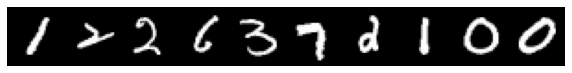

In [8]:
# Data augmentation 
transform = transforms.Compose([transforms.ToTensor(),  # data의 type을 Tensor로 변경
                                transforms.Normalize(mean = (0.5,), std=(0.5, ) )]) #  [-1,1] 사이의 값으로 normalized 시킨다. 
# Data Loading
dataloader = DataLoader(
    datasets.MNIST(
     root = "data/mnist", # 경로 지정
     train = True,        # train data를 받아옴. (False 면 test data를 받아옴)
     download = True,    # dataset이 없는 경우 True, (다운로드가 안되는경우, False로 설정 후 가장 위를 참조)
     transform = transform),
     batch_size = batch_size,
     shuffle = True,     # Epoch 마다 데이터가 학습되는 순서를 바꿈
    )

# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 10], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()
plt.close('all')

## Composition of Model Structure - DO NOT CHANGE

* The below code prepares you an instance of the unified neural network to setup the InfoGAN implementation.

In [9]:
z_size=62
code_size=12
# Initialise the network.
netG = Generator(z_size,code_size).to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Task 2. Implement the learning structure of InfoGAN 
Complete the learning procedure of the InfoGAN with the above implementations. 
* Setup the loss function and its two optimizers corresponding to the learnings of 1) **Generator,QHead** and 2) **Discriminator,DHead**.
* Iterate through the examples to maximize the **Discriminator,DHead**, and then to minimize **Generator,QHead**.
* Make sure that the loss of **Discriminator,DHead** and **Generator,QHead** are printed as the standard cell output, as the below. Try to follow the format for the TA's convenience.

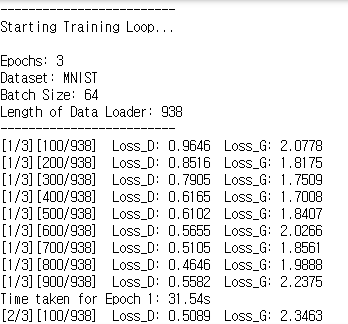

In [10]:
###############################################
# You can use this code box to implement the training codes
# - icmoon

optimD = optim.Adam(
    [{"params": discriminator.parameters()}, {"params": netD.parameters()}], lr=learning_rate, betas=(beta1, beta2)
)
optimG = optim.Adam(
    [{"params": netG.parameters()}, {"params": netQ.parameters()}], lr=learning_rate, betas=(beta1, beta2)
)

print("-" * 25)
print("Starting Training Loop...\n")
print(f"Epochs: {num_epochs}\nDataset: MNIST\nBatch Size: {batch_size}\nLength of Data Loader: {len(dataloader)}")
print("-" * 25)

img_list = []
G_losses = []
D_losses = []
iters = 0
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        b_size = data.size(0)
        real_data = data.to(device)

        optimD.zero_grad()
        label = torch.full((b_size,), real_label, device=device)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label.float())
        loss_real.backward()

        label.fill_(fake_label)
        noise, code, idx = noise_sample(num_dis_c, dis_c_dim, num_con_c, num_z, b_size, device)
        fake_data = netG(noise, code)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label.float())
        loss_fake.backward()

        D_loss = loss_real + loss_fake
        optimD.step()

        optimG.zero_grad()

        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label.float())

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        dis_loss = 0
        for j in range(num_dis_c):
            dis_loss += criterionQ_dis(q_logits[:, j * 10 : j * 10 + 10], target[j])

        con_loss = 0
        if num_con_c != 0:
            latent = torch.cat((noise, code), 1)
            con_loss = (
                criterionQ_con(latent[:, num_z + num_dis_c * dis_c_dim :].view(-1, num_con_c), q_mu, q_var) * 0.1
            )

        G_loss = gen_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if i != 0 and i % 100 == 0:
            print(
                f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {D_loss.item():.4f}\tLoss_G: {G_loss.item():.4f}"
            )

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print(f"Time taken for Epoch {epoch + 1}: {epoch_time:.2f}s")


plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve MNIST")

-------------------------
Starting Training Loop...

Epochs: 3
Dataset: MNIST
Batch Size: 128
Length of Data Loader: 469
-------------------------


RuntimeError: Given transposed=1, weight of size [74, 1024, 1, 1], expected input[128, 86, 1, 1] to have 74 channels, but got 86 channels instead

## Sample Generations - DO NOT CHANGE

* The below code prepares you the sample generation procedures by arbitrarily setting the latent information. 
* **You need to demonstrate your working code can generate samples.**

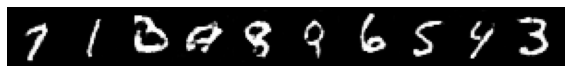

In [ ]:
# Image Generation

lstDiscreteLatentCondition = []
lstContinuousLatentCondition = []
intNumToGenerate = 10

for i in range(intNumToGenerate):
    lstTempDiscrete = [0.0]*10
    lstTempContinuous = [0.0]*2
    
    lstTempDiscrete[i%10] = 1
    lstTempContinuous[0] = (2.0/intNumToGenerate) * i - 1.0
    
    lstDiscreteLatentCondition.append(lstTempDiscrete)
    lstContinuousLatentCondition.append(lstTempContinuous)

generated_img = netG.sample(lstDiscreteLatentCondition,lstContinuousLatentCondition).detach().cpu()  
    
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()    